In [3]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import pandas as pd
import sys
import random 
import matplotlib.pyplot as plt
sys.path.append('../../')

from intracluster_filtering.data_selector import DataSelector

In [4]:
# Fijar semillas
np.random.seed(41)
tf.random.set_seed(41)
random.seed(41)

# 1. Iris dataset

In [5]:
# Load data
data_iris = load_iris()

X_ = data_iris['data']
y_ = data_iris['target']

# One hot encoding
enc = OneHotEncoder(sparse_output=False)
y_ = y_.reshape(-1, 1)
target = enc.fit_transform(y_)

# Split into train and test
X_train, X_val, y_train, y_val = train_test_split(X_, target, test_size=0.4, random_state=0)


print("Input Shape: ", X_train.shape, X_val.shape)
print("Target Shape: ", y_train.shape, y_val.shape)

Input Shape:  (90, 4) (60, 4)
Target Shape:  (90, 3) (60, 3)


## 2. Model

In [6]:
# Create the model
class CustomModel(tf.keras.Model):
    def __init__(self, D_in, H1, H2, D_out):
        super(CustomModel, self).__init__()
        self.cl1 = tf.keras.layers.Dense(H1, activation='relu', input_shape=(D_in,))
        self.cl2 = tf.keras.layers.Dense(H1, activation='relu')
        self.cl3 = tf.keras.layers.Dense(H2, activation='relu')
        self.fc1 = tf.keras.layers.Dense(D_out, activation='softmax')

    def call(self, inputs):
        x = self.cl1(inputs)
        x = self.cl2(x)
        x = self.cl3(x)
        x = self.fc1(x)
        return x

    def inspector_out(self, inputs):
        x = self.cl1(inputs)
        x = self.cl2(x)
        x = self.cl3(x)  
        return x

In [7]:
# Instantiate the model
model_iris = CustomModel(4, 40, 40, 3)

2024-08-10 20:09:44.604365: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-10 20:09:44.604400: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kerlynsm-ZenBook-UX325EA-UX325EA): /proc/driver/nvidia/version does not exist
2024-08-10 20:09:44.605110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. First training phase: without filtering

In [8]:
# Training configuration
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_iris.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy',      
                               patience=20,                 
                               verbose=1,                   
                               mode='max',                  
                               restore_best_weights=True)   

# Training
model_iris.fit(X_train, y_train, epochs=3000, batch_size=30, verbose = 0, validation_data=(X_val, y_val), callbacks=[early_stopping])

Restoring model weights from the end of the best epoch: 54.
Epoch 74: early stopping


### Results

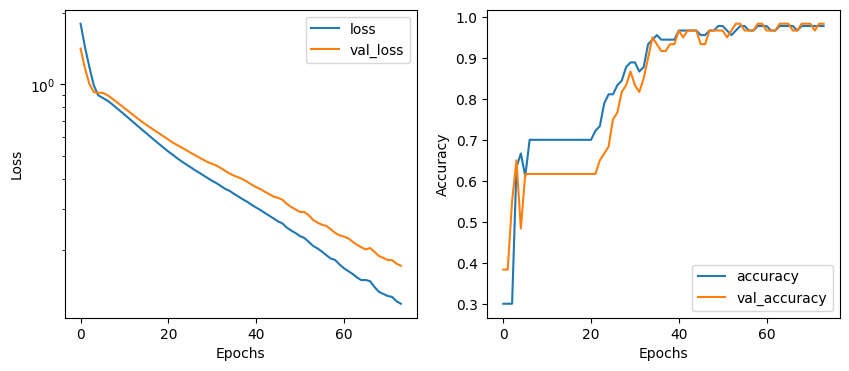

In [9]:
# Loss function graph and accuracy graph
plt.figure(figsize=(10, 4))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(model_iris.history.history['loss'], label='loss')
plt.plot(model_iris.history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Accuracy graph 
plt.subplot(1, 2, 2)
plt.plot(model_iris.history.history['accuracy'], label='accuracy')
plt.plot(model_iris.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [10]:
# Evaluation for the best weights for the model
loss_train, accuracy_train = model_iris.evaluate(X_train, y_train, verbose=0)
loss_val, accuracy_val = model_iris.evaluate(X_val, y_val, verbose=0)
print(f"Train loss: {loss_train}")
print(f"Train accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")

Train loss: 0.2045213133096695
Train accuracy: 0.9777777791023254
Validation loss: 0.26870688796043396
Validation accuracy: 0.9833333492279053


## 4. Second training phase: with filtering

In [11]:
epochs = 20                    # Number of epochs
epoch_init_filter = 1          # Epoch at which the filter starts
update_period_in_epochs = 5    # Update period in epochs

In [12]:
# Instantiate data selector
data_selector = DataSelector(X_train, y_train, epoch_init_filter , update_period_in_epochs, filter_percentile=0.05, random_state=280296, train_with_outliers=False)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Set up the callback to save the best weights
checkpoint_filepath = 'model_checkpoint_2.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0)

In [14]:
# Dictionary to store the training information
train_info = {
    'train_losses': [],
    'val_losses': [],
    'train_accuracies': [],
    'val_accuracies': []
}

X_clusterized = {}
x_index_filter = {}
index_original = {}
epochs_succ_filt = []

x_index_filter_aux = []
# Training loop
for epoch in range(epochs):
    # Get filtered training sets
    X_tr_aux, y_tr_aux, index_original_aux, x_index_aux, cluster_aux = data_selector.get_train_data(epoch=epoch, model=model_iris, outs_posibilities=list(np.unique(y_)), explained_variance = 0.95)
    if not x_index_filter_aux == x_index_aux:
        X_clusterized[epoch] = cluster_aux
        index_original[epoch] = index_original_aux
        x_index_filter[epoch] = list(set(x_index_aux).difference(set(x_index_filter_aux)))
        x_index_filter_aux[:] = x_index_aux[:]
        epochs_succ_filt.append(epoch)
    
    # Fit the model
    history = model_iris.fit(X_tr_aux, y_tr_aux, epochs=1, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback] )
    
    # Store the training information
    train_info['train_losses'].append(history.history['loss'])
    train_info['val_losses'].append(history.history['val_loss'])
    train_info['train_accuracies'].append(history.history['accuracy'])
    train_info['val_accuracies'].append(history.history['val_accuracy'])

    print(f"Epoch: {epoch+1}")

Epoch: 1
PCA done: retained 95.0% of the variance with 2 components
Size of the training set: 90
All classes have just one cluster associated
Number of probabilities below the threshold 1.0 for the actual class 0:  0
Number of probabilities below the threshold 0.84 for the actual class 1:  2
Number of probabilities below the threshold 0.79 for the actual class 2:  2
Remove data: [72 81 59 29]
Data has been filtered
Size of data removed: 4
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
PCA done: retained 95.0% of the variance with 2 components
Size of the training set: 86
All classes have just one cluster associated
Number of probabilities below the threshold 1.0 for the actual class 0:  0
Number of probabilities below the threshold 0.98 for the actual class 1:  2
Number of probabilities below the threshold 0.99 for the actual class 2:  1
Remove data: [19 73 16]
Data has been filtered
Size of data removed: 3
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
PCA done: retained 95.0% of the va

In [15]:
# Index for all detected IO
index_filter = [item for sublist in x_index_filter.values() for item in sublist]

print(f'Initial sets training: {X_train.shape[0]}')
print(f'Final sets training: {X_train.shape[0] - len(index_filter)}')

Initial sets training: 90
Final sets training: 83


### Results


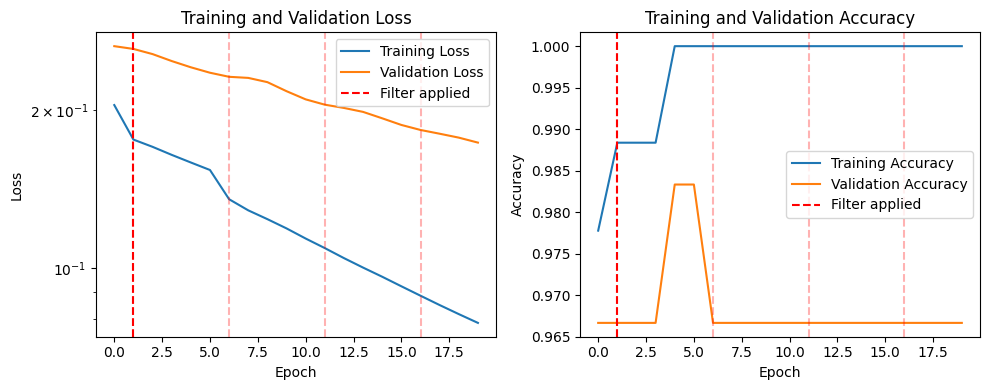

In [16]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_info['train_losses'], label='Training Loss')
plt.plot(train_info['val_losses'], label='Validation Loss')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='Filter applied')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_info['train_accuracies'], label='Training Accuracy')
plt.plot(train_info['val_accuracies'], label='Validation Accuracy')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='Filter applied')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Load best weights
model_iris.load_weights(checkpoint_filepath)

# Evaluation Accuracy
loss_train_new, accuracy_train_new = model_iris.evaluate(X_tr_aux, y_tr_aux, verbose=0)
loss_val_new, accuracy_val_new = model_iris.evaluate(X_val, y_val, verbose=0)

print(f"Training loss: Previous {loss_train} vs current {loss_train_new}")
print(f"Training accuracy: Previous {accuracy_train} vs current {accuracy_train_new}")
print(f"Validation loss: Previous {loss_val} vs current {loss_val_new}")
print(f"Validation accuracy: Previous {accuracy_val} vs current {accuracy_val_new}")


Training loss: Previous 0.2045213133096695 vs current 0.14295175671577454
Training accuracy: Previous 0.9777777791023254 vs current 1.0
Validation loss: Previous 0.26870688796043396 vs current 0.24117214977741241
Validation accuracy: Previous 0.9833333492279053 vs current 0.9833333492279053


## 5. Outliers Visualization

### Visualization with two PCA components

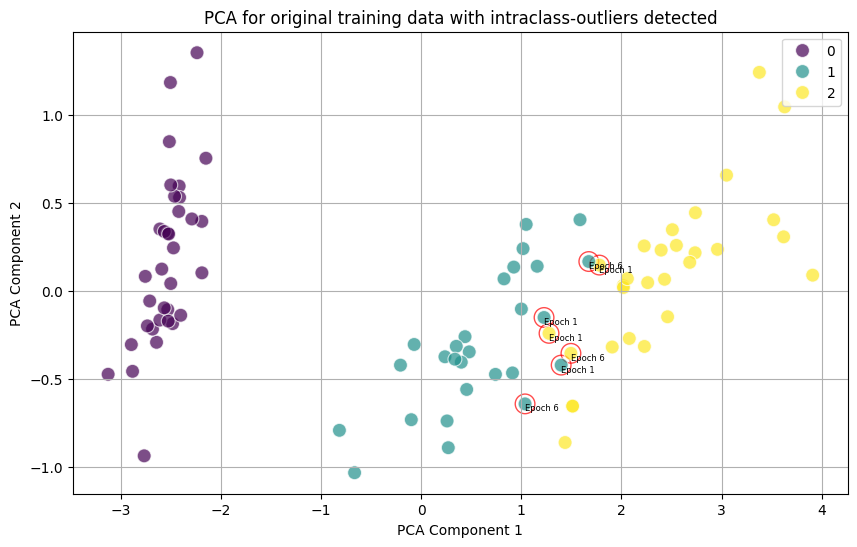

In [18]:
from sklearn.decomposition import PCA 

# Apply PCA to reduce dimensionality to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# DataFrame with the transformed data and labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['class'] = y_train.argmax(axis=1)

plt.figure(figsize=(10, 6))

# Highlight the points that were filtered (detected outliers)
for epoch in epochs_succ_filt:
    for (x, y) in X_pca[x_index_filter[epoch]]:
        plt.scatter(x, y, color='none', s=200, label=None, edgecolor='red', alpha=0.7)
        plt.text(x, y, f'Epoch {epoch}', fontsize=6, color='black', ha='left', va='top')
        
# Scatter plot of the original dataset
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='class', palette='viridis', s=100, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA for original training data with intraclass-outliers detected')
plt.legend()
plt.grid(True)


plt.show()

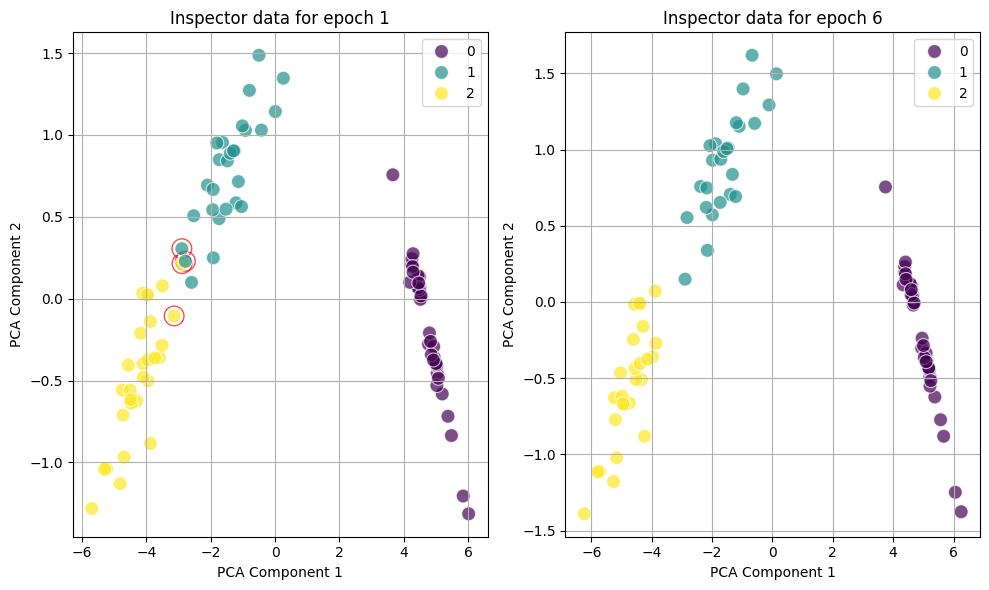

In [19]:
# Plot inspector_data
fig, axs = plt.subplots(nrows=1, ncols=len(epochs_succ_filt), figsize=(10, 6))

# Highlight the points that were filtered (detected outliers)
index_original
for i in range(len(epochs_succ_filt)):
    df = pd.DataFrame(X_clusterized[epochs_succ_filt[i]], columns=['PCA1', 'PCA2'])
    if i>0:
        df['class'] = y_train[index_original[epochs_succ_filt[i-1]],:].argmax(axis=1)
    else:
        df['class'] = y_train.argmax(axis=1)
        for (x, y) in X_clusterized[epochs_succ_filt[i]][x_index_filter[epochs_succ_filt[i]]]:
           axs[i].scatter(x, y, color='none', s=200, label=None, edgecolor='red', alpha=0.7)
       
    sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='class', palette='viridis', s=100, alpha=0.7, ax = axs[i])
    axs[i].set_xlabel('PCA Component 1')
    axs[i].set_ylabel('PCA Component 2')
    axs[i].set_title(f'Inspector data for epoch {epochs_succ_filt[i]}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

### Visualization with three PCA components

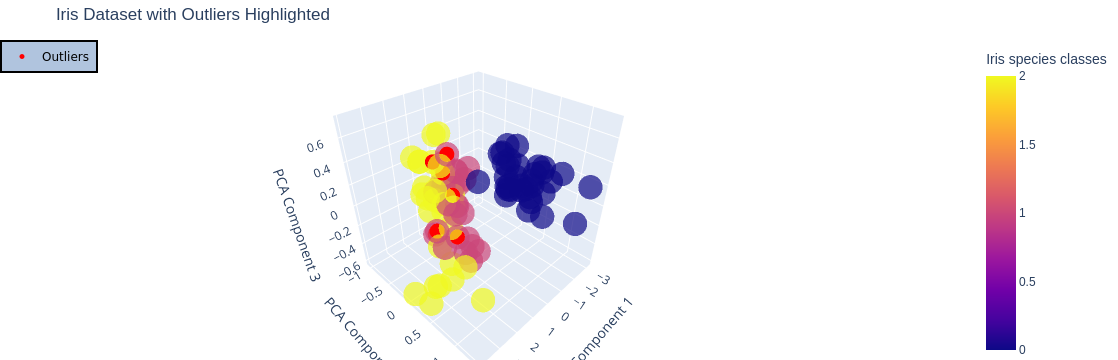

In [21]:
import plotly.express as px
import plotly.graph_objects as go

# Apply PCA to reduce dimensionality to 3 components for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

# DataFrame with the transformed data and labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['class'] = y_train.argmax(axis=1)
df_pca['outlier'] = 'Normal'
df_pca.loc[index_filter, 'outlier'] = 'Outlier'

# Scatter plot of the original dataset
fig = px.scatter_3d(df_pca, x='PCA1', y='PCA2', z='PCA3', color='class',
                    title='Iris Dataset with Outliers Highlighted',
                    labels={'class': 'Iris species classes'},
                    opacity=0.7)

# Highlight the points that were filtered (detected outliers)
fig.add_trace(go.Scatter3d(
    x=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA1'],
    y=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA2'],
    z=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA3'],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Outliers'
))

# Update the chart design
fig.update_layout(scene=dict(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    zaxis_title='PCA Component 3'),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)

fig.show()